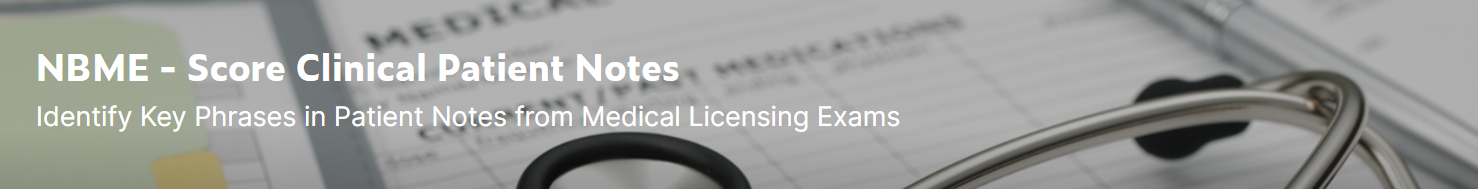

## Data decsription:

### Important Terms
Clinical Case: The scenario (e.g., symptoms, complaints, concerns) the Standardized Patient presents to the test taker (medical student, resident or physician). Ten clinical cases are represented in this dataset.

Patient Note: Text detailing important information related by the patient during the encounter (physical exam and interview).

Feature: A clinically relevant concept. A rubric describes the key concepts relevant to each case.

### Training Data

### patient_notes.csv - A collection of about 40,000 Patient Note history portions. 
Only a subset of these have features annotated. You may wish to apply unsupervised learning techniques on the notes without annotations. The patient notes in the test set are not included in the public version of this file.
>- pn_num - A unique identifier for each patient note.
>- case_num - A unique identifier for the clinical case a patient note represents.
>- pn_history - The text of the encounter as recorded by the test taker.

### features.csv - The rubric of features (or key concepts) for each clinical case.
>- feature_num - A unique identifier for each feature.
>- case_num - A unique identifier for each case.
>- feature_text - A description of the feature.

### train.csv - Feature annotations for 1000 of the patient notes, 100 for each of ten cases.
>- id - Unique identifier for each patient note / feature pair.
>- pn_num - The patient note annotated in this row.
>- feature_num - The feature annotated in this row.
>- case_num - The case to which this patient note belongs.
>- annotation - The text(s) within a patient note indicating a feature. A feature may be indicated multiple times within a single note.
>- location - Character spans indicating the location of each annotation within the note. Multiple spans may be needed to represent an annotation, in which case the spans are delimited by a semicolon ;.

## Competition evaluation metrics: 
This competition is evaluated by a micro-averaged F1 score.

**What is going on:**
Use the publicly available models to calculate the predictions_v3_l, predictions_v1_l and predictions_v1_b. These are lists of np.arrays. Each np.array corresponds to one patient note / feature number combination and represents probabilities that n-th letter in the patient note should be selected as belonging to the feature.

Then in the very end, take these probabilities and for each patient note+feature number combine them in a simple linear combination:
```
predictions = []
for p1, p2, p3 in zip(predictions_v3_l, predictions_v1_l, predictions_v1_b):
    predictions.append(w1*p1 + w2*p2 + w3*p3)
```
The weights `w1,w2,w3` are obtained from playing with the out-of-fold results that comes with each trained model

## Weights

In [ ]:
w1 = 0.5     # Deberta v3 large
w2 = 0.4     # Deberta v1 large
w3 = 0.18    # Deberta v1 base

## Imports

In [ ]:
# The following is necessary if you want to use the fast tokenizer for deberta v2 or v3
# This must be done before importing transformers
import shutil
from pathlib import Path

transformers_path = Path("/opt/conda/lib/python3.7/site-packages/transformers")

input_dir = Path("../input/deberta-v2-3-fast-tokenizer")

convert_file = input_dir / "convert_slow_tokenizer.py"
conversion_path = transformers_path/convert_file.name

if conversion_path.exists():
    conversion_path.unlink()

shutil.copy(convert_file, transformers_path)
deberta_v2_path = transformers_path / "models" / "deberta_v2"

for filename in ['tokenization_deberta_v2.py', 'tokenization_deberta_v2_fast.py']:
    filepath = deberta_v2_path/filename
    
    if filepath.exists():
        filepath.unlink()

    shutil.copy(input_dir/filename, filepath)

In [ ]:
import os
import gc
import ast
import sys
import copy
import json
import math
import string
import pickle
import random
import itertools
import re
from termcolor import colored
import ipywidgets as widgets 
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt
import joblib
from nltk import flatten
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers.models.deberta_v2.tokenization_deberta_v2_fast import DebertaV2TokenizerFast
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
def seed_everything(seed=42):
    '''
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.
    '''
    random.seed(seed)
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # When running on the CuDNN backend, two further options must be set
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(seed=42)

## Helper functions for scoring

In [ ]:
def micro_f1(preds, truths):
    """
    Micro f1 on binary arrays.

    Args:
        preds (list of lists of ints): Predictions.
        truths (list of lists of ints): Ground truths.

    Returns:
        float: f1 score.
    """
    # Micro : aggregating over all instances
    preds = np.concatenate(preds)
    truths = np.concatenate(truths)
    
    return f1_score(truths, preds)


def spans_to_binary(spans, length=None):
    """
    Converts spans to a binary array indicating whether each character is in the span.

    Args:
        spans (list of lists of two ints): Spans.

    Returns:
        np array [length]: Binarized spans.
    """
    length = np.max(spans) if length is None else length
    binary = np.zeros(length)
    for start, end in spans:
        binary[start:end] = 1
        
    return binary


def span_micro_f1(preds, truths):
    """
    Micro f1 on spans.

    Args:
        preds (list of lists of two ints): Prediction spans.
        truths (list of lists of two ints): Ground truth spans.

    Returns:
        float: f1 score.
    """
    bin_preds = []
    bin_truths = []
    for pred, truth in zip(preds, truths):
        if not len(pred) and not len(truth):
            continue
        length = max(np.max(pred) if len(pred) else 0, np.max(truth) if len(truth) else 0)
        bin_preds.append(spans_to_binary(pred, length))
        bin_truths.append(spans_to_binary(truth, length))
        
    return micro_f1(bin_preds, bin_truths)

In [ ]:
def create_labels_for_scoring(df):
    # example: ['0 1', '3 4'] -> ['0 1; 3 4']
    df['location_for_create_labels'] = [ast.literal_eval(f'[]')] * len(df)
    for i in range(len(df)):
        lst = df.loc[i, 'location']
        if lst:
            new_lst = ';'.join(lst)
            df.loc[i, 'location_for_create_labels'] = ast.literal_eval(f'[["{new_lst}"]]')
    # create labels
    truths = []
    for location_list in df['location_for_create_labels'].values:
        truth = []
        if len(location_list) > 0:
            location = location_list[0]
            for loc in [s.split() for s in location.split(';')]:
                start, end = int(loc[0]), int(loc[1])
                truth.append([start, end])
        truths.append(truth)
        
    return truths


def get_char_probs(texts, predictions, tokenizer):
    results = [np.zeros(len(t)) for t in texts]
    for i, (text, prediction) in enumerate(zip(texts, predictions)):
        encoded = tokenizer(text, 
                            add_special_tokens=True,
                            return_offsets_mapping=True)
        for idx, (offset_mapping, pred) in enumerate(zip(encoded['offset_mapping'], prediction)):
            start = offset_mapping[0]
            end = offset_mapping[1]
            results[i][start:end] = pred
            
    return results


def get_results(char_probs, th=0.5):
    results = []
    for char_prob in char_probs:
        result = np.where(char_prob >= th)[0] + 1
        result = [list(g) for _, g in itertools.groupby(result, key=lambda n, c=itertools.count(): n - next(c))]
#         result = [f"{min(r)} {max(r)}" for r in result]
        result = [f"{min(r)} {max(r)}" if min(r) != max(r) else f"{min(r)-1} {max(r)}" if min(r)!=0 else f"{min(r)} {max(r)}" for r in result]
        result = ";".join(result)
        results.append(result)
        
    return results


def get_predictions(results):
    predictions = []
    for result in results:
        prediction = []
        if result != "":
            for loc in [s.split() for s in result.split(';')]:
                start, end = int(loc[0]), int(loc[1])
                prediction.append([start, end])
        predictions.append(prediction)
        
    return predictions


def get_score(y_true, y_pred):
    return span_micro_f1(y_true, y_pred)

## Data Loading

In [ ]:
main_dir="../input/nbme-score-clinical-patient-notes/"

test = pd.read_csv(main_dir+'test.csv')
train = pd.read_csv(main_dir+'train.csv')
submission = pd.read_csv(main_dir+'sample_submission.csv')
features = pd.read_csv(main_dir+'features.csv')
patient_notes = pd.read_csv(main_dir+'patient_notes.csv')

In [ ]:
# Correcting inconsistencies
display(features.loc[27, 'feature_text'])
features.loc[27, 'feature_text'] = "Last-Pap-smear-1-year-ago"
display(features.loc[27, 'feature_text'])

In [ ]:
train['annotation'] = train['annotation'].apply(ast.literal_eval)
train['location'] = train['location'].apply(ast.literal_eval)

# Reference: https://www.kaggle.com/code/yasufuminakama/nbme-deberta-base-baseline-train
# Correct incorrect annotations
train.loc[338, 'annotation'] = ast.literal_eval('[["father heart attack"]]')
train.loc[338, 'location'] = ast.literal_eval('[["764 783"]]')

train.loc[621, 'annotation'] = ast.literal_eval('[["for the last 2-3 months"]]')
train.loc[621, 'location'] = ast.literal_eval('[["77 100"]]')

train.loc[655, 'annotation'] = ast.literal_eval('[["no heat intolerance"], ["no cold intolerance"]]')
train.loc[655, 'location'] = ast.literal_eval('[["285 292;301 312"], ["285 287;296 312"]]')

train.loc[1262, 'annotation'] = ast.literal_eval('[["mother thyroid problem"]]')
train.loc[1262, 'location'] = ast.literal_eval('[["551 557;565 580"]]')

train.loc[1265, 'annotation'] = ast.literal_eval('[[\'felt like he was going to "pass out"\']]')
train.loc[1265, 'location'] = ast.literal_eval('[["131 135;181 212"]]')

train.loc[1396, 'annotation'] = ast.literal_eval('[["stool , with no blood"]]')
train.loc[1396, 'location'] = ast.literal_eval('[["259 280"]]')

train.loc[1591, 'annotation'] = ast.literal_eval('[["diarrhoe non blooody"]]')
train.loc[1591, 'location'] = ast.literal_eval('[["176 184;201 212"]]')

train.loc[1615, 'annotation'] = ast.literal_eval('[["diarrhea for last 2-3 days"]]')
train.loc[1615, 'location'] = ast.literal_eval('[["249 257;271 288"]]')

train.loc[1664, 'annotation'] = ast.literal_eval('[["no vaginal discharge"]]')
train.loc[1664, 'location'] = ast.literal_eval('[["822 824;907 924"]]')

train.loc[1714, 'annotation'] = ast.literal_eval('[["started about 8-10 hours ago"]]')
train.loc[1714, 'location'] = ast.literal_eval('[["101 129"]]')

train.loc[1929, 'annotation'] = ast.literal_eval('[["no blood in the stool"]]')
train.loc[1929, 'location'] = ast.literal_eval('[["531 539;549 561"]]')

train.loc[2134, 'annotation'] = ast.literal_eval('[["last sexually active 9 months ago"]]')
train.loc[2134, 'location'] = ast.literal_eval('[["540 560;581 593"]]')

train.loc[2191, 'annotation'] = ast.literal_eval('[["right lower quadrant pain"]]')
train.loc[2191, 'location'] = ast.literal_eval('[["32 57"]]')

train.loc[2553, 'annotation'] = ast.literal_eval('[["diarrhoea no blood"]]')
train.loc[2553, 'location'] = ast.literal_eval('[["308 317;376 384"]]')

train.loc[3124, 'annotation'] = ast.literal_eval('[["sweating"]]')
train.loc[3124, 'location'] = ast.literal_eval('[["549 557"]]')

train.loc[3858, 'annotation'] = ast.literal_eval('[["previously as regular"], ["previously eveyr 28-29 days"], ["previously lasting 5 days"], ["previously regular flow"]]')
train.loc[3858, 'location'] = ast.literal_eval('[["102 123"], ["102 112;125 141"], ["102 112;143 157"], ["102 112;159 171"]]')

train.loc[4373, 'annotation'] = ast.literal_eval('[["for 2 months"]]')
train.loc[4373, 'location'] = ast.literal_eval('[["33 45"]]')

train.loc[4763, 'annotation'] = ast.literal_eval('[["35 year old"]]')
train.loc[4763, 'location'] = ast.literal_eval('[["5 16"]]')

train.loc[4782, 'annotation'] = ast.literal_eval('[["darker brown stools"]]')
train.loc[4782, 'location'] = ast.literal_eval('[["175 194"]]')

train.loc[4908, 'annotation'] = ast.literal_eval('[["uncle with peptic ulcer"]]')
train.loc[4908, 'location'] = ast.literal_eval('[["700 723"]]')

train.loc[6016, 'annotation'] = ast.literal_eval('[["difficulty falling asleep"]]')
train.loc[6016, 'location'] = ast.literal_eval('[["225 250"]]')

train.loc[6192, 'annotation'] = ast.literal_eval('[["helps to take care of aging mother and in-laws"]]')
train.loc[6192, 'location'] = ast.literal_eval('[["197 218;236 260"]]')

train.loc[6380, 'annotation'] = ast.literal_eval('[["No hair changes"], ["No skin changes"], ["No GI changes"], ["No palpitations"], ["No excessive sweating"]]')
train.loc[6380, 'location'] = ast.literal_eval('[["480 482;507 519"], ["480 482;499 503;512 519"], ["480 482;521 531"], ["480 482;533 545"], ["480 482;564 582"]]')

train.loc[6562, 'annotation'] = ast.literal_eval('[["stressed due to taking care of her mother"], ["stressed due to taking care of husbands parents"]]')
train.loc[6562, 'location'] = ast.literal_eval('[["290 320;327 337"], ["290 320;342 358"]]')

train.loc[6862, 'annotation'] = ast.literal_eval('[["stressor taking care of many sick family members"]]')
train.loc[6862, 'location'] = ast.literal_eval('[["288 296;324 363"]]')

train.loc[7022, 'annotation'] = ast.literal_eval('[["heart started racing and felt numbness for the 1st time in her finger tips"]]')
train.loc[7022, 'location'] = ast.literal_eval('[["108 182"]]')

train.loc[7422, 'annotation'] = ast.literal_eval('[["first started 5 yrs"]]')
train.loc[7422, 'location'] = ast.literal_eval('[["102 121"]]')

train.loc[8876, 'annotation'] = ast.literal_eval('[["No shortness of breath"]]')
train.loc[8876, 'location'] = ast.literal_eval('[["481 483;533 552"]]')

train.loc[9027, 'annotation'] = ast.literal_eval('[["recent URI"], ["nasal stuffines, rhinorrhea, for 3-4 days"]]')
train.loc[9027, 'location'] = ast.literal_eval('[["92 102"], ["123 164"]]')

train.loc[9938, 'annotation'] = ast.literal_eval('[["irregularity with her cycles"], ["heavier bleeding"], ["changes her pad every couple hours"]]')
train.loc[9938, 'location'] = ast.literal_eval('[["89 117"], ["122 138"], ["368 402"]]')

train.loc[9973, 'annotation'] = ast.literal_eval('[["gaining 10-15 lbs"]]')
train.loc[9973, 'location'] = ast.literal_eval('[["344 361"]]')

train.loc[10513, 'annotation'] = ast.literal_eval('[["weight gain"], ["gain of 10-16lbs"]]')
train.loc[10513, 'location'] = ast.literal_eval('[["600 611"], ["607 623"]]')

train.loc[11551, 'annotation'] = ast.literal_eval('[["seeing her son knows are not real"]]')
train.loc[11551, 'location'] = ast.literal_eval('[["386 400;443 461"]]')

train.loc[11677, 'annotation'] = ast.literal_eval('[["saw him once in the kitchen after he died"]]')
train.loc[11677, 'location'] = ast.literal_eval('[["160 201"]]')

train.loc[12124, 'annotation'] = ast.literal_eval('[["tried Ambien but it didnt work"]]')
train.loc[12124, 'location'] = ast.literal_eval('[["325 337;349 366"]]')

train.loc[12279, 'annotation'] = ast.literal_eval('[["heard what she described as a party later than evening these things did not actually happen"]]')
train.loc[12279, 'location'] = ast.literal_eval('[["405 459;488 524"]]')

train.loc[12289, 'annotation'] = ast.literal_eval('[["experienced seeing her son at the kitchen table these things did not actually happen"]]')
train.loc[12289, 'location'] = ast.literal_eval('[["353 400;488 524"]]')

train.loc[13238, 'annotation'] = ast.literal_eval('[["SCRACHY THROAT"], ["RUNNY NOSE"]]')
train.loc[13238, 'location'] = ast.literal_eval('[["293 307"], ["321 331"]]')

train.loc[13297, 'annotation'] = ast.literal_eval('[["without improvement when taking tylenol"], ["without improvement when taking ibuprofen"]]')
train.loc[13297, 'location'] = ast.literal_eval('[["182 221"], ["182 213;225 234"]]')

train.loc[13299, 'annotation'] = ast.literal_eval('[["yesterday"], ["yesterday"]]')
train.loc[13299, 'location'] = ast.literal_eval('[["79 88"], ["409 418"]]')

train.loc[13845, 'annotation'] = ast.literal_eval('[["headache global"], ["headache throughout her head"]]')
train.loc[13845, 'location'] = ast.literal_eval('[["86 94;230 236"], ["86 94;237 256"]]')

train.loc[14083, 'annotation'] = ast.literal_eval('[["headache generalized in her head"]]')
train.loc[14083, 'location'] = ast.literal_eval('[["56 64;156 179"]]')

In [ ]:
train['annotation_length'] = train['annotation'].apply(len)

In [ ]:
print(train.shape)
print('# Patient notes:', train['pn_num'].nunique())
print('# Cases:', train['case_num'].nunique())
print('# Features:', train['feature_num'].nunique())
train.head()

In [ ]:
print(test.shape)
test.head()

In [ ]:
print(submission.shape)
submission.head()

In [ ]:
print(features.shape)
print('# Features:', features['feature_num'].nunique())
print('# Cases:', features['case_num'].nunique())
features.head()

In [ ]:
print(patient_notes.shape)
print('# Patient notes:', patient_notes['pn_num'].nunique())
print('# Cases:', patient_notes['case_num'].nunique())
patient_notes.head()

In [ ]:
patient_notes['pn_history length'] = patient_notes['pn_history'].apply(lambda x: len(x.split(' ')))
display(patient_notes['pn_history length'].describe().reset_index().T)
fig = px.histogram(patient_notes, x='pn_history length', title = 'Distribution of patient note length')
fig.show()

In [ ]:
patient_notes_data, patient_notes_in_train_data = set(patient_notes['pn_num'].unique().tolist()), set(train['pn_num'].unique().tolist())
venn2((patient_notes_in_train_data, patient_notes_data), set_labels = ('Patient notes annotated in train dataset', 'All patient notes'))
plt.show()

In [ ]:
patient_notes[(patient_notes['case_num']==1)]['pn_history'].iloc[0]

In [ ]:
patient_notes[(patient_notes['case_num']==1)]['pn_history'].iloc[1]

In [ ]:
features[features['case_num']==1].reset_index(drop = True)

In [ ]:
features.groupby(['case_num']).agg({'feature_num':'nunique'}).reset_index().sort_values(by = 'feature_num', ascending = False)

In [ ]:
train = train.merge(features, on=['feature_num', 'case_num'], how='left')
train = train.merge(patient_notes, on=['pn_num', 'case_num'], how='left')
display(train.head())

In [ ]:
test = test.merge(features, on=['feature_num', 'case_num'], how='left')
test = test.merge(patient_notes, on=['pn_num', 'case_num'], how='left')
display(test.head())

In [ ]:
note_id = 1165
temp = train[train['pn_num']==note_id]
text = patient_notes[patient_notes['pn_num']==note_id]['pn_history'].iloc[0]
formatted_text = text
temp = train[train['pn_num']==note_id]

In [ ]:
list_1 = features['feature_text'].unique().tolist()
list_colors = ['grey', 'red', 'green',
'yellow',
'blue',
'magenta',
'cyan',
'white']
list_2 = [random.sample(list_colors,1) for x in range(0, len(list_1))]

feature_to_color_dict = {list_1[i]: list_2[i] for i in range(0, len(list_1))}

def replace_specific_text(normal_text, full_text, loc_k_start, loc_k_end, color):
    text = normal_text[loc_k_start:loc_k_end]
    if len(re.findall(text, normal_text))==1:
        return full_text.replace(text, colored(text, color, 'on_white', attrs=['bold']))
    else:
        text = normal_text[loc_k_start:loc_k_end]
        start_indices_for_color_chars = [i for i in range(len(full_text)) if full_text.startswith('\x1b[1m\x1b[47m\x1b[31m', i)]
        end_indices_for_color_chars = [i for i in range(len(full_text)) if full_text.startswith('\x1b[0m', i)]
        start_indices_for_color_chars = [start_indices_for_color_chars[x] - x*len('\x1b[1m\x1b[47m\x1b[31m') for x in range(0, len(start_indices_for_color_chars))]
        flags = [1 for x in start_indices_for_color_chars if x<loc_k_start]
        id_start = loc_k_start + sum(flags) * (len('\x1b[1m\x1b[47m\x1b[31m') + len('\x1b[0m'))
        id_end = id_start + len(text)
        return full_text[0:id_start] + colored(full_text[id_start:id_end], color, 'on_white', attrs=['bold']) + full_text[id_end:]

def showcase_patient_note(note_id):
    print(colored('\nPatient note:\n', attrs=['bold']))
    temp = train[train['pn_num']==note_id]
    text = patient_notes[patient_notes['pn_num']==note_id]['pn_history'].iloc[0]
    formatted_text = text
    temp = train[train['pn_num']==note_id]
    for i in range(0, temp.shape[0]):
        locations = temp['location'].iloc[i]
        if len(locations) != 0:
            locations = locations[0].split(';')
            for k in range(0, len(locations)):
                loc_k = locations[k]
                if ';' in loc_k:
                    loc_k = loc_k.split(';')[0]
                loc_k_start = int(loc_k.split(' ')[0])
                if len(loc_k.split(' '))==2:
                    loc_k_end = int(loc_k.split(' ')[1])
                else:
                    loc_k_end = loc_k_start + 1
#                 formatted_text = formatted_text.replace(text[loc_k_start:loc_k_end], colored(text[loc_k_start:loc_k_end], 'red', 'on_white', attrs=['bold']))
                color = 'red'
                formatted_text = replace_specific_text(text, formatted_text, loc_k_start, loc_k_end, color)

    print(formatted_text)

    print(colored('\nAnnotations in train data corresponding to various features:\n', attrs=['bold']))
    display(train[train['pn_num']==note_id][['annotation', 'feature_text','location']].reset_index(drop = True))
    
widgets.interactive(showcase_patient_note, note_id = train['pn_num'].unique().tolist())

In [ ]:
# Subset the train data for saving memory
n=200
ids = train['pn_num'].unique().tolist()[0:n]
train = train[train['pn_num'].isin(ids)].reset_index(drop = True)

## Deberta v3 large

In [ ]:
class CFG:
    num_workers=4
    path="../input/deberta-v3-large-5-folds-public/"
    config_path=path+'config.pth'
    model="microsoft/deberta-v3-large"
    batch_size=32
    fc_dropout=0.2
    max_len=354
    seed=42
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]

In [ ]:
tokenizer = DebertaV2TokenizerFast.from_pretrained('../input/deberta-tokenizer')
CFG.tokenizer = tokenizer

In [ ]:
display(test[(test['id']=='00016_000')]['pn_history'].iloc[0])
tokenizer(test[(test['id']=='00016_000')]['pn_history'].iloc[0], add_special_tokens=False)

In [ ]:
display(test[(test['id']=='00016_000')]['feature_text'].iloc[0])
tokenizer(test[(test['id']=='00016_000')]['feature_text'].iloc[0], add_special_tokens=False)

In [ ]:
tokenizer(test[(test['id']=='00016_000')]['pn_history'].iloc[0], test[(test['id']=='00016_000')]['feature_text'].iloc[0], add_special_tokens=False)

In [ ]:
def prepare_input(cfg, text, feature_text):
    inputs = cfg.tokenizer(text, feature_text, 
                           add_special_tokens=True,
                           max_length=CFG.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
        
    return inputs


class TestDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.feature_texts = df['feature_text'].values
        self.pn_historys = df['pn_history'].values

    def __len__(self):
        return len(self.feature_texts)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, 
                               self.pn_historys[item], 
                               self.feature_texts[item])
        
        return inputs
    
class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.feature_texts = df['feature_text'].values
        self.pn_historys = df['pn_history'].values
        self.annotation_lengths = df['annotation_length'].values
        self.locations = df['location'].values

    def __len__(self):
        return len(self.feature_texts)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, 
                               self.pn_historys[item], 
                               self.feature_texts[item])
        
#         label = create_label(self.cfg, 
#                              self.pn_historys[item], 
#                              self.annotation_lengths[item], 
#                              self.locations[item])
        
        return inputs

In [ ]:
class ScoringModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, 1)
        self._init_weights(self.fc)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]

        return last_hidden_states

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        
        return output

In [ ]:
def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    
    return predictions

In [ ]:
fold = 0
CFG.path+f"{CFG.model.split('/')[1]}_fold{fold}_best.pth"

In [ ]:
train_dataset = TrainDataset(CFG, train)
train_loader = DataLoader(train_dataset,
                         batch_size=CFG.batch_size,
                         shuffle=False,
                         num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
predictions = []
for fold in CFG.trn_fold:
    model = ScoringModel(CFG, config_path=CFG.config_path, pretrained=False)
    
    path = CFG.path+f"{CFG.model.split('/')[1]}_fold{fold}_best.pth"
#     path = '../input/deberta-model/deberta-v3-large_epoch_8.pth'
    state = torch.load(path,
                           map_location=torch.device('cpu'))
       
    model.load_state_dict(state['model'])
    prediction = inference_fn(train_loader, model, device)
    prediction = prediction.reshape((len(train), CFG.max_len))
    char_probs = get_char_probs(train['pn_history'].values, prediction, CFG.tokenizer)
    predictions.append(char_probs)
    del model, state, prediction, char_probs
    gc.collect()
    torch.cuda.empty_cache()
    
predictions_v3_l = np.mean(predictions, axis=0)

In [ ]:
print(predictions_v3_l.shape)
predictions_v3_l[0][0:5]

## Deberta large

In [ ]:
# ====================================================
# CFG
# ====================================================
class CFG:
    num_workers=4
    path="../input/debertalarge/"
    config_path=path+'config.pth'
    model="microsoft/deberta-large"
    batch_size=24
    fc_dropout=0.2
    max_len=466
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]

In [ ]:
# ====================================================
# tokenizer
# ====================================================
CFG.tokenizer = AutoTokenizer.from_pretrained(CFG.path+'tokenizer/')

In [ ]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, 1)
        self._init_weights(self.fc)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        return last_hidden_states

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

In [ ]:
# ====================================================
# inference
# ====================================================
def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [ ]:
train_dataset = TrainDataset(CFG, train)
train_loader = DataLoader(train_dataset,
                         batch_size=CFG.batch_size,
                         shuffle=False,
                         num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
predictions = []
for fold in CFG.trn_fold:
    model = CustomModel(CFG, config_path=CFG.config_path, pretrained=False)
    state = torch.load(CFG.path+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(train_loader, model, device)
    prediction = prediction.reshape((len(train), CFG.max_len))
    char_probs = get_char_probs(train['pn_history'].values, prediction, CFG.tokenizer)
    predictions.append(char_probs)
    del model, state, prediction, char_probs; gc.collect()
    torch.cuda.empty_cache()
predictions_v1_l = np.mean(predictions, axis=0)

## Deberta base

In [ ]:
# ====================================================
# CFG
# ====================================================
class CFG:
    num_workers=4
    path="../input/nbme-deberta-base-baseline-train/"
    config_path=path+'config.pth'
    model="microsoft/deberta-base"
    batch_size=24
    fc_dropout=0.2
    max_len=466
    seed=42
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]

In [ ]:
# ====================================================
# tokenizer
# ====================================================
CFG.tokenizer = AutoTokenizer.from_pretrained(CFG.path+'tokenizer/')

In [ ]:
train_dataset = TrainDataset(CFG, train)
train_loader = DataLoader(train_dataset,
                         batch_size=CFG.batch_size,
                         shuffle=False,
                         num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
predictions = []
for fold in CFG.trn_fold:

    model = CustomModel(CFG, config_path=CFG.config_path, pretrained=False)
    state = torch.load(CFG.path+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(train_loader, model, device)
    prediction = prediction.reshape((len(train), CFG.max_len))
    char_probs = get_char_probs(train['pn_history'].values, prediction, CFG.tokenizer)
    predictions.append(char_probs)
    del model, state, prediction, char_probs; gc.collect()
    torch.cuda.empty_cache()
predictions_v1_b = np.mean(predictions, axis=0)

## Combine

In [ ]:
predictions = []
for p1, p2, p3 in zip(predictions_v3_l, predictions_v1_l, predictions_v1_b):
    predictions.append(w1*p1 + w2*p2 + w3*p3)

In [ ]:
results = get_results(predictions)

In [ ]:
train['Prediction locations'] = results

def get_correct_locations(x):
    pred_loc = x['Prediction locations'].split(';')
    pn_note = x['pn_history']
    correct_pred_loc = []
    all_correct_pred_loc = []

    if pred_loc[0]!='':
        # Retrieve full words from patient note
        for i in pred_loc:
            start_loc = i.split(' ')[0]
            j = int(start_loc)-1
            correct_start_loc = start_loc
            while (j>=0) & (pn_note[j] != ' ') & (pn_note[j] != '"'):
                correct_start_loc = j
                j = j-1
            correct_list = f'{correct_start_loc} ' + i.split(' ')[1]
            correct_pred_loc.append(correct_list)

        # Combine overlapping locations
        combine_flag = []
        count = 0
        for i in correct_pred_loc:
            if count!=0:
                if int(i.split(' ')[0]) in [m for m in range(int(correct_pred_loc[count-1].split(' ')[0]), int(correct_pred_loc[count-1].split(' ')[1]))]:
                    combine_flag.append(1)
                    all_correct_pred_loc[-1] = all_correct_pred_loc[-1].split(' ')[0] + ' ' + i.split(' ')[1]
                else:
                    combine_flag.append(0)
                    all_correct_pred_loc.append(i)
            else:
                combine_flag.append(0)
                all_correct_pred_loc.append(i)
            count += 1
        all_correct_pred_loc = ';'.join(all_correct_pred_loc)
    else:
        all_correct_pred_loc = x['Prediction locations']
    return all_correct_pred_loc

def get_prediction_text(x):
    out = []
    for i in x['Prediction locations (corrected)'].split(';'):
        if i.split(' ')[0].strip()!='':
            out.append([x['pn_history'][int(i.split(' ')[0]): int(i.split(' ')[1])]])
    return out

train['Prediction locations (corrected)'] = train.apply(lambda x: get_correct_locations(x), axis = 1)
train['Prediction'] = train.apply(lambda x: get_prediction_text(x), axis = 1)

In [ ]:
# example: ['0 1', '3 4'] -> ['0 1; 3 4']
train['location_for_create_labels'] = [ast.literal_eval(f'[]')] * len(train)
for i in range(len(train)):
    lst = train.loc[i, 'location']
    if lst:
        new_lst = ';'.join(lst)
        train.loc[i, 'location_for_create_labels'] = ast.literal_eval(f'[["{new_lst}"]]')
# create labels
truths = []
for location_list in train['location_for_create_labels'].values:
    truth = []
    if len(location_list) > 0:
        location = location_list[0]
        for loc in [s.split() for s in location.split(';')]:
            start, end = int(loc[0]), int(loc[1])
            truth.append([start, end])
    truths.append(truth)

In [ ]:
def get_model_performance_metrics(x):
    out = []
    for i in x['Prediction locations (corrected)'].split(';'):
        if i.split(' ')[0].strip()!='':
            out = out + [x for x in range(int(i.split(' ')[0]), int(i.split(' ')[1]))]
            
    truth = []
    if len(x['location_for_create_labels'])!=0:
        for i in x['location_for_create_labels'][0].split(';'):
            if i.split(' ')[0].strip()!='':
                truth = truth + [x for x in range(int(i.split(' ')[0]), int(i.split(' ')[1]))]
    tp = len(set.intersection(set(out), set(truth)))
    fp = len(set(out) - set.intersection(set(out), set(truth)))
    fn = len(set(truth) - set.intersection(set(out), set(truth)))

    if (tp + fn)==0:
        recall = 0
    else:
        recall = tp/(tp + fn)
    if (tp + fp)==0:
        precision = 0
    else:
        precision = tp/(tp + fp)
    if (recall + precision) == 0:
        f1 = 0
    else:
        f1 = 2 * recall * precision/(recall + precision)
   
    return [tp, fp, fn, recall, precision, f1]

In [ ]:
train['TP, FP, FN, Recall, Precision, F1'] = train.apply(lambda x: get_model_performance_metrics(x), axis = 1)
train['F1 score'] = train['TP, FP, FN, Recall, Precision, F1'].apply(lambda x: x[-1])
train['Recall'] = train['TP, FP, FN, Recall, Precision, F1'].apply(lambda x: x[-3])
train['Precision'] = train['TP, FP, FN, Recall, Precision, F1'].apply(lambda x: x[-2])
train.head(10)

In [ ]:
train[(train['annotation_length']!=0) & (train['Prediction'].apply(lambda x: len(x)==0))]['pn_history'].iloc[0]

In [ ]:
print('FP records:', train[(train['annotation_length']==0) & (train['Prediction'].apply(lambda x: len(x)!=0))].shape[0])
print('FN records:', train[(train['annotation_length']!=0) & (train['Prediction'].apply(lambda x: len(x)==0))].shape[0])

In [ ]:
print('False positve rate:', train[(train['annotation_length']==0) & (train['Prediction'].apply(lambda x: len(x)!=0))].shape[0]/(train[(train['annotation_length']==0) & (train['Prediction'].apply(lambda x: len(x)!=0))].shape[0] + train[(train['annotation_length']==0) & (train['Prediction'].apply(lambda x: len(x)==0))].shape[0])*100,'%')

In [ ]:
sample_pn_num = 10180

print('\nPatient note:\n\n' + train[train['pn_num']==sample_pn_num]['pn_history'].iloc[0])
print('\nPredictions from model:\n\n' + ' | '.join(list(flatten(train[train['pn_num']==sample_pn_num]['Prediction'].tolist()))))

In [ ]:
train.sample(20)[['id','pn_num','pn_history','feature_text','annotation','Prediction','TP, FP, FN, Recall, Precision, F1']].reset_index(drop = True)

In [ ]:
joblib.dump(train, 'train_data_with_predictions.pkl')